# Lead question: How do the costs of international travel by plane and train compare?

3 August 2018

Updated 10 August 2018

**By Tom Wills**

_Notebook layout based on [Visa Applications to Germany from Africa](https://github.com/dw-data/Visa-applications-Africa-Asia/blob/master/Visa-Applications-Germany-Africa.ipynb) by Gianna-Carina Gruen._

**Overview** Travellers are increasingly environmentally aware, while new and improved high speed train routes such as Berlin-Warsaw, Zürich-Milan and London-Amsterdam promise convenient low-carbon journeys across the continent.

This story will compare the costs of travelling these routes along several dimensions:
* Monetary cost to passenger (ticket price)
* Time cost to passsenger (journey duration)
* Environmental cost (greenhouse gas emissions)
* Monetary cost to society of greenhouse gas emissions (Social Cost of Carbon)

## Background

Greenhouse gas emissions are the main cause of climate change, which threatens devastating consequences for the planet. Reducing emissions is a challenge for every country. In Germany, the question has been brought into sharp focus by reports that [the nation is on course to miss the government's 2020 emissions reduction target](https://www.dw.com/en/germany-to-miss-2020-greenhouse-gas-emissions-target/a-44199562) by a considerable margin.

Against this backdrop, there is increasing awareness on the part of the general public of the carbon consequences of our individual lifestyle choices.

International travel is a significant component of greenhouse gas emissions in developed countries, and air travel is a particularly potent source of emissions due to high fuel consumption and the high altitudes at which combustion takes place.

High speed trains supposedly offer a more environmentally friendly alternative to air travel. However, large numbers of travellers still prefer flying due to time or ticket price considerations.

This story will use data analysis to provide a new perspective on the costs of our travel choices.

## Selection of routes

Routes on which high-speed train services compete with airlines have been selected. They have been chosen to include major cities in a spread of different European countries. Three of the train routes have been upgraded in recent years, improving journey times. In the case of Berlin-Warsaw, the journey time is expected to be improved next year.

* **Zurich-Milan** The train was rerouted through the newly-built Gotthard Base Tunnel in December 2016, reducing the journey time [from 4 hours to 3.5 hours](https://www.sbb.ch/content/dam/sbb/en/pdf/en_geschaeftsreisen/en_ueber-uns/SBB_GK_Gotthard_Factsheet_e.pdf). The tunnel [cost €11 billion](https://www.dw.com/en/first-passenger-train-travels-through-gotthard-base-tunnel-the-worlds-longest-rail-tunnel/a-36725053) to build. _Sources: SBB; Deutsche Welle_
* **London-Amsterdam** Eurostar [launched](https://www.seat61.com/trains-and-routes/direct-eurostar-london-to-amsterdam.htm) a direct service in April 2018. _Source: Seat61_
* **Paris-Barcelona** In [December 2013](https://www.seat61.com/Spain.htm#London-Barcelona_by_daytime_train) a direct train was launched via the new Perpignan-Barcelona high speed line, another multi-billion-Euro project. _Source: Seat61_
* **Berlin-Warsaw** The train journey is currently 6.5 hours, but this [is expected to fall from Winter 2018](https://loco2.com/en/destinations/trains-to-warsaw) thanks to [investment in the line](https://www.railfreight.com/corridors/2017/10/23/investment-on-the-polish-e20-line-improvement-or-waste-of-money/) in Poland. It [has been suggested](https://www.globalrailwayreview.com/article/5060/constructing-and-launching-high-speed-lines-in-poland/) that the trip could one day be cut to 3 hours. _Sources: Loco2; RailFreight.com; Global Railway Review_
* **London-Marseille** The direct train connection between England's capital and the French city on the Mediterranean coast was launched in 2015. _Source: Seat61_
* **Munich-Budapest** This route to a popular tourist destination is served by Austrian trains. _Source: Seat61_

## Ticket price & journey time data

After evaluating a number of websites, I have identified **[GoEuro](https://www.goeuro.com/)** as a good one-stop-shop for ticket prices and journey times by rail and air. The site combines prices scraped from airlines, train companies and coach operators in a single search. It also provides optional figures for airport transit times.

Unfortunately there were multiple problems in programmatically obtaining ticket prices from GoEuro. The anti-scraping CAPTCHA kicked in as soon as Selenium was used to access the site, and the UI implementation was also non-trivial.

As an alternative I have obtained airline ticket prices from Google Flights and train tickets the Trainline.

**Trainline** offers train ticket prices and journey times for a selected date. These can be queried using structured URLs and the results extracted using Selenium.

In [ ]:
# Running this cell will fire up Selenium and send ~800 requests to Trainline
# Output is printed to the console
# Data collected on 2 August 2018 is available in Trains.csv

from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
#binary = FirefoxBinary('/opt/firefox/firefox')
import datetime

def getTrainPrices(searchorigin, searchdestination, searchdate, searchtime):
    # Search Trainline.eu for trains on a given route at a given date and time
    # Output reuslts data in CSV format to the console
    wd.get('https://www.trainline.eu/search/' + searchorigin + '/' + searchdestination + '/' + searchdate + '-' + searchtime)
    element = WebDriverWait(wd, 60).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".search__button button"))
    )
    wd.find_elements_by_css_selector('.search__button button')[0].click()
    element = WebDriverWait(wd, 60).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".search__results--line"))
    )
    results = wd.find_elements_by_css_selector('.search__results--line')
    date = wd.find_elements_by_css_selector('.search__results--header .first')[0].text
    route = wd.find_elements_by_css_selector('.search__results--title span')[0].text

    for result in results:
        times_els = result.find_elements_by_css_selector('.time')
        if len(times_els) > 0:
            times = times_els[0].text
        else:
            times = '-'
        duration_changes_els = result.find_elements_by_css_selector('.timeline__label')
        if len(duration_changes_els) > 0:
            duration_changes = duration_changes_els[0].text
        else:
            duration_changes = '-'
        second_class_price_els =result.find_elements_by_css_selector('.has-price span')
        if len(second_class_price_els) > 0:
            second_class_price = second_class_price_els[0].text
        else:
            second_class_price = '-'
        print(*[route, date, times, duration_changes, second_class_price], sep=',')

wd = webdriver.Firefox(firefox_binary=binary)

origin = 'zurich-hb'
destination = 'milano-centrale'

for origin, destination in [('zurich-hb', 'milano-centrale'),
                            ('london', 'amsterdam'),
                            ('london', 'marseille'),
                            ('paris', 'barcelona'),
                            ('munich', 'budapest'),
                            ('berlin', 'warsaw')]:
    # Search for trains each day from tomorrow up to 60 days ahead
    base = datetime.datetime.today()
    date_list = [base + datetime.timedelta(days=x) for x in range(1, 60)]
    for date in date_list:
        wd = webdriver.Firefox(firefox_binary=binary)
        getTrainPrices(origin, destination, str(date.strftime('%Y-%m-%d')), '06:00')
        wd.close()

**Google Flights** offers a calendar showing the lowest price for a given route each day across a two-month period.

It is important to specify direct flights in the search parameters, and to deselect any train companies that appear in the results (such as Deutsche Bahn for relevant routes).

Once the calendar is in view, the following JavaScript can be pasted into the browser console in order to extract the prices for each day of the month, along with the names of the selected origin and destination. This approach avoids having to send multiple requests to Google Flights.

The text from the console can be saved to a file and treated as CSV data.

The journey time for flights was taken as a constant.

In [ ]:
# Grab ticket prices and dates from a Google Flights calendar
# and output them to the terminal as CSV data

# To use this script, search for a flight on Google Flights, click the price calendar, then copy & paste this code into the browser console.
# Data collected on 2 August 2018 is available in Flights.csv

originText = document.getElementsByClassName('gws-flights-form__airport-input')[0].getElementsByClassName('gws-flights-form__location-list')[0].getElementsByTagName('span')[2].textContent;

destText = document.getElementsByClassName('gws-flights-form__airport-input')[1].getElementsByClassName('gws-flights-form__location-list')[0].getElementsByTagName('span')[2].textContent;

months = document.getElementsByTagName('calendar-month');
for (var i = 0; i < months.length; i++)
{
	month = months[i];	
	monthText = month.getElementsByTagName('month-header')[0].textContent;
	days = month.getElementsByTagName('calendar-day');
	for (var j = 0; j < days.length; j++)
	{
		day = days[j];
		dayText = day.getElementsByClassName('gws-travel-calendar__day-label')[0].textContent;
		priceText = day.getElementsByTagName('span')[0].textContent;
		if (priceText) {
			console.log(originText + ',' + destText + ',' + monthText + ',' + dayText + ',' + priceText);
		};
	}
};

## CO2 emissions data

The **[EcoPassenger](http://www.ecopassenger.org)** service provides CO2 emissions figures for rail and air modes, tailored to specific routes. Its algorithm was developed by the Institute for Energy and Environmental Research and is based on internationally accepted methodologies and emission factors. The [methodology](http://ecopassenger.hafas.de/hafas-res/download/Ecopassenger_Methodology_Data.pdf) is documented in some detail and takes into account several specific characteristics of each route and mode to generate estimates. These include:
* Load factor (i.e. typical number of passengers on each train/plane)
* Estimated route length
* Aircraft or train type
* Electricity supply mix in countries traversed by train
* Radiative forcing index for flights

The EcoPassenger figures for train and air emissions are a good basis for our calculations that will be more robust than attempting to model new emissions figures ourselves.

## Social Cost of Carbon

The Social Cost of Carbon is a concept developed by economists that attempts to model the future impact of climate change arising from greenhouse gas emissions in present-day financial terms. It has gained some political prominence - for example, the US EPA adopted a Social Cost of Carbon, although this has since been attacked by the Trump administration. In this application of the concept, the idea is to help policymakers decide which emissions-reducing policies are worth the financial cost. It has also been suggested that the Social Cost of Carbon might help determine the level at which a Carbon Tax ought to be set.

Peer-reviewed proposals for how much the cost of carbon should be vary by several orders of magnitude, because the model is extremely sensitive to different predictions of the consequences of climate change and different economic assumptions. There is also dissent within economics about how useful the SCC is. _(Source: Oxford Handbook of the Macroeconomics of Global Warming)_

In order to demonstrate to readers the _potential_ costs of their flights, I have selected a high cost of carbon based on a catastrophic climate change scenario. This is much higher than the US EPA cost of carbon. We should make clear to readers that there is no scientific or economic consensus around any particular value for the Social Cost of Carbon, and the true cost could turn out to be much higher or much lower.

I think this approach is preferable to choosing a middle value for the Social Cost of Carbon from among the published papers, because a middle value would not convey the risk of catastrophic climate change. Similarly, quoting a range would imply a level of certainty to the high and low figures that is not supported by the scientific literature. The best approach is therefore to make clear that we are using a high figure and explain to readers why there is considerable uncertainty around the Social Cost of Carbon, perhaps with a quote from an expert.

# Load modules

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
import dateutil.parser
import numpy as np
import pylab
from itertools import product

from IPython.display import display, Markdown, Latex

from geopy.geocoders import Nominatim
from geopy.distance import great_circle

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 30)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [5]:
# Radar Chart function

# This cell copied from https://matplotlib.org/gallery/api/radar_chart.html

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def __init__(self, *args, **kwargs):
            super(RadarAxes, self).__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta

def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

# Social Cost of Carbon - unit conversion

In [6]:
# This cell calculates the social cost of carbon in EUR per kg CO2,
# based on the high figure given by Ceronsky et al (2011)

# High figure for SCC from http://www.esri.ie/pubs/WP392.pdf#page=26
# Social cost of carbon in 2010 US dollars per tonne of Carbon
scc_2010_usd_tc = 1879

# Convert 2010 dollars to 2017 dollars
# source: World Bank - GDP deflator United States
# https://data.worldbank.org/indicator/NY.GDP.DEFL.ZS?locations=US
# 100 = 2010 dollars
usd_2017_gdp_deflator = 112.1
scc_2017_usd_tc = scc_2010_usd_tc / 100 * usd_2017_gdp_deflator

# Convert tonnes of carbon to tonnes of CO2
# source: IPCC http://www.ipcc.ch/ipccreports/tar/wg3/index.php?idp=477
# 3.67 tonnes CO2 = 1 tonne carbon
co2_carbon = 3.67
scc_2017_usd_tco2 = scc_2017_usd_tc / co2_carbon

# Convert US dollars to Euros
# Source: https://www.reuters.com/finance/currencies/quote?srcCurr=EUR&destCurr=USD
# Mid-market price as of 07:20 UTC 23/07/2018
# 1 USD = 1.1728 EUR

eurusd = 1.1728
scc_2017_eur_tco2 = scc_2017_usd_tco2 / eurusd

# Load travel costs & emissions data

Emissions data was collected manually from EcoPassenger for train and air travel on the same routes. The options used were:
* Utilization per train and flight: Average load factor
* Global warming extra charge of flight: CO2-emissions with climate factor
* Electricity mix of railways: National Production Mix

Emissions for transport to/from the airport are included.

In [7]:
# Read in the csv file containing the
# travel costs data

# Raw travel time is given in minutes
# Ticket price is given in EUR
# EcoPassengerCO2 is given in kg

travel_costs = pd.read_csv("Flights-Trains.csv")

In [8]:
travel_costs.head()

,Route,Mode,WeeksAhead,EcoPassengerCO2,Raw travel time,Ticket price
0,Berlin-Warsaw,Plane,1,156,85,181
1,Berlin-Warsaw,Plane,2,156,85,175
2,Berlin-Warsaw,Plane,3,156,85,175
3,Berlin-Warsaw,Plane,4,156,85,175
4,Berlin-Warsaw,Plane,5,156,85,178


In [9]:
travel_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
Route              72 non-null object
Mode               72 non-null object
WeeksAhead         72 non-null int64
EcoPassengerCO2    72 non-null int64
Raw travel time    72 non-null int64
Ticket price       72 non-null int64
dtypes: int64(4), object(2)
memory usage: 3.5+ KB


In [10]:
# Add the SCC for each record
# 1000 kg = 1 tonne

travel_costs['SCC'] = travel_costs['EcoPassengerCO2'] * scc_2017_eur_tco2 / 1000

# Add the ticket price including SCC

travel_costs['TicketPriceIncludingSCC'] = round(travel_costs['Ticket price'] + travel_costs['SCC']).astype(int)

In [11]:
# Add a column for aggregation in the charts
travel_costs['RouteWks'] = travel_costs['Route'] + travel_costs['WeeksAhead'].astype(str)

In [12]:
# Reshape data to match format required by the Radar Chart function

dimensions = ['Raw travel time', 'Ticket price', 'EcoPassengerCO2']

cases = []

for route in travel_costs['RouteWks'].unique():
    title = route
    route_data = travel_costs[travel_costs.RouteWks == route]
    case_data = route_data[dimensions].values.astype(int).tolist()
    cases.append((title, case_data))
    
data = cases

In [13]:
# This cell rescales the data such that each metric is represented by a figure between 0 and 1.
# The scales are constant across the multiple radar plots in each diagram.

# Reshape data to match format required by the Radar Chart function

dimensions = ['Raw travel time', 'Ticket price', 'EcoPassengerCO2']
idxdimensions = ['Raw travel timeIndex', 'Ticket priceIndex', 'EcoPassengerCO2Index']

rescaled_cases = []

for route in travel_costs['RouteWks'].unique():
    title = route
    route_data = travel_costs[travel_costs.RouteWks == route]
    for dimension in dimensions:
        route_data[dimension + 'Index'] = route_data[dimension] / travel_costs[dimension].max()
    case_data = route_data[idxdimensions].values.tolist()
    rescaled_cases.append((title, case_data))
    
rescaled_data = rescaled_cases

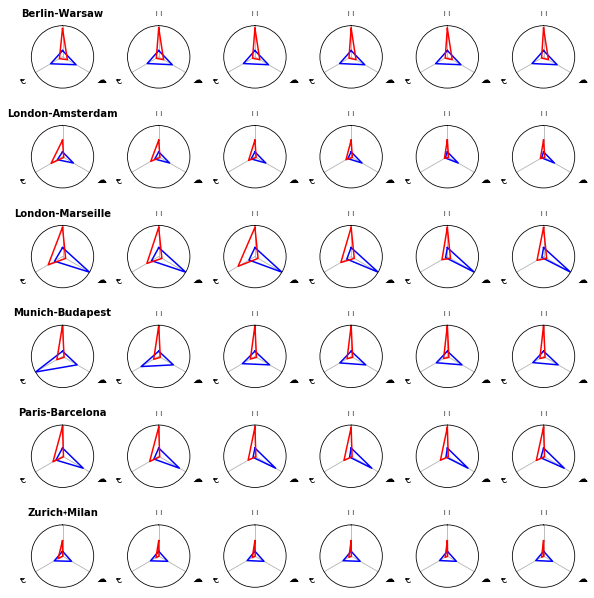

In [14]:
# Plot the travel costs data on Radar Charts

# This cell adapted from https://matplotlib.org/gallery/api/radar_chart.html

N = len(dimensions)
theta = radar_factory(N, frame='circle')

spoke_labels = ['🕒', '€', '☁️']

fig, axes = plt.subplots(figsize=(10, 4), nrows=6, ncols=6,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.60, top=2, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
labels = ['Plane', 'Train']

# Plot the four cases from the data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), rescaled_data):
    ax.set_rgrids([])
    if int(title[-1]) > 1:
        title = ''
    else:
        title = title[:-1]
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
    
    ax.set_varlabels(spoke_labels)
    ax.set_ylim(0,1)
    
plt.show()

In [48]:
# Average the six weeks for each route-mode

travel_costs_averaged = travel_costs.groupby(['Route', 'Mode', 'EcoPassengerCO2', 'SCC'])['Ticket price', 'TicketPriceIncludingSCC', 'Raw travel time'].mean().reset_index()
#travel_costs_averaged
# Add Travel time?

,Route,Mode,EcoPassengerCO2,SCC,Ticket price,TicketPriceIncludingSCC,Raw travel time
0,Berlin-Warsaw,Plane,156,76.342604,176.500000,252.500000,85.000000
1,Berlin-Warsaw,Train,56,27.405037,36.000000,63.000000,383.000000
2,London-Amsterdam,Plane,125,61.171958,51.166667,112.166667,65.000000
3,London-Amsterdam,Train,14,6.851259,93.666667,100.666667,221.833333
4,London-Marseille,Plane,311,152.195832,73.333333,225.333333,120.000000
5,London-Marseille,Train,36,17.617524,165.000000,183.000000,389.500000
6,Munich-Budapest,Plane,168,82.215112,228.500000,310.500000,70.000000
7,Munich-Budapest,Train,18,8.808762,67.666667,76.666667,413.833333
8,Paris-Barcelona,Plane,238,116.471409,47.833333,163.833333,110.000000
9,Paris-Barcelona,Train,11,5.383132,118.333333,123.333333,389.166667


In [49]:
# Reshape data to match format required by the Radar Chart function

dimensions = ['Raw travel time', 'Ticket price', 'EcoPassengerCO2']

cases = []

for route in travel_costs_averaged['Route'].unique():
    title = route
    route_data = travel_costs[travel_costs.Route == route]
    case_data = route_data[dimensions].values.astype(int).tolist()
    cases.append((title, case_data))
    
data = cases

In [50]:
# This cell rescales the data such that each metric is represented by a figure between 0 and 1.
# The scales are constant across the multiple radar plots in each diagram.

# Reshape data to match format required by the Radar Chart function

dimensions = ['Raw travel time', 'Ticket price', 'EcoPassengerCO2']
idxdimensions = ['Raw travel timeIndex', 'Ticket priceIndex', 'EcoPassengerCO2Index']

rescaled_cases = []

for route in travel_costs_averaged['Route'].unique():
    title = route
    route_data = travel_costs_averaged[travel_costs_averaged.Route == route]
    for dimension in dimensions:
        route_data[dimension + 'Index'] = route_data[dimension] / travel_costs_averaged[dimension].max()
    case_data = route_data[idxdimensions].values.tolist()
    rescaled_cases.append((title, case_data))
    
rescaled_data = rescaled_cases

Train vs plane: journey time, carbon emissions and ticket price


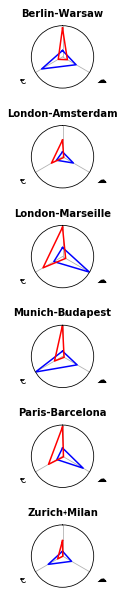

Prices averaged over 6 weeks
Sources: Google Flights; Trainline; IFEU EcoPassenger; Deutsche Welle analysis


In [57]:
# Plot the travel costs data on Radar Charts

# This cell adapted from https://matplotlib.org/gallery/api/radar_chart.html

N = len(dimensions)
theta = radar_factory(N, frame='circle')

spoke_labels = ['🕒', '€', '☁️']

fig, axes = plt.subplots(figsize=(10, 4), nrows=6, ncols=1,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.60, top=2, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
labels = ['Plane', 'Train']

# Plot the four cases from the data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), rescaled_data):
    ax.set_rgrids([])
    title = title
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
    
    ax.set_varlabels(spoke_labels)
    ax.set_ylim(0,1)
    
print('Train vs plane: journey time, carbon emissions and ticket price')
plt.show()
print('Prices averaged over 6 weeks')
print('Sources: Google Flights; Trainline; IFEU EcoPassenger; Deutsche Welle analysis')

In [16]:
# Table: Ticket prices by route, mode and weeks until journey

pd.pivot_table(travel_costs, values='Ticket price', index=['Route', 'Mode'], columns=['WeeksAhead'])

WeeksAhead                1    2    3    4    5    6
Route            Mode                               
Berlin-Warsaw    Plane  181  175  175  175  178  175
                 Train   47   37   36   33   33   30
London-Amsterdam Plane   78   60   58   50   32   29
                 Train  173  121   97   78   44   49
London-Marseille Plane  121  109   91   66   27   26
                 Train  217  180  256  156   82   99
Munich-Budapest  Plane  411  267  191  172  167  163
                 Train   86   76   69   62   57   56
Paris-Barcelona  Plane  100   73   29   23   21   41
                 Train  145  138  103  109  105  110
Zurich-Milan     Plane  125  125  118  122  118  118
                 Train   67   42   41   35   33   30

In [17]:
# Table: Raw journey time by route and mode
travel_costs['Travel time'] = pd.to_timedelta(travel_costs['Raw travel time'], unit='m')
wk1 = travel_costs[travel_costs.WeeksAhead == 1]
wk1[['Route', 'Mode', 'Travel time']]
pd.pivot_table(wk1, values='Travel time', index=['Route'], columns='Mode', aggfunc=lambda x: x)

Mode,Plane,Train
Route,,
Berlin-Warsaw,01:25:00,06:19:00
London-Amsterdam,01:05:00,03:41:00
London-Marseille,02:00:00,06:30:00
Munich-Budapest,01:10:00,06:57:00
Paris-Barcelona,01:50:00,06:36:00
Zurich-Milan,01:05:00,03:26:00


In [60]:
# Table: Journey time by route and mode with 3hr air transit added
travel_costs['Travel time w transit'] = travel_costs['Raw travel time'] + (180 * (travel_costs['Mode'] == 'Plane'))
travel_costs['Travel time'] = pd.to_timedelta(travel_costs['Travel time w transit'], unit='m')
wk1 = travel_costs[travel_costs.WeeksAhead == 1]
wk1[['Route', 'Mode', 'Travel time']]
pd.pivot_table(wk1, values='Travel time', index=['Route'], columns='Mode', aggfunc=lambda x: x)

Mode,Plane,Train
Route,,
Berlin-Warsaw,04:25:00,06:19:00
London-Amsterdam,04:05:00,03:41:00
London-Marseille,05:00:00,06:30:00
Munich-Budapest,04:10:00,06:57:00
Paris-Barcelona,04:50:00,06:36:00
Zurich-Milan,04:05:00,03:26:00


In [67]:
# Table: Emissions by route and mode
wk1 = travel_costs[travel_costs.WeeksAhead == 1]
wk1[['Route', 'Mode', 'EcoPassengerCO2']]
pd.pivot_table(wk1, values='EcoPassengerCO2', index=['Route'], columns='Mode', aggfunc=lambda x: x)

Mode,Plane,Train
Route,,
Berlin-Warsaw,156,56
London-Amsterdam,125,14
London-Marseille,311,36
Munich-Budapest,168,18
Paris-Barcelona,238,11
Zurich-Milan,104,3


In [75]:
# Table: Ticket price with added SCC by route and mode (4 weeks ahead)
wk1 = travel_costs[travel_costs.WeeksAhead == 4]
wk1[['Route', 'Mode', 'Ticket price', 'TicketPriceIncludingSCC']]
pd.pivot_table(wk1, values=['Ticket price', 'TicketPriceIncludingSCC'], index=['Route'], columns='Mode', aggfunc=lambda x: x)

Ticket price       TicketPriceIncludingSCC      
Mode                    Plane Train                   Plane Train
Route                                                            
Berlin-Warsaw             175    33                     251    60
London-Amsterdam           50    78                     111    85
London-Marseille           66   156                     218   174
Munich-Budapest           172    62                     254    71
Paris-Barcelona            23   109                     139   114
Zurich-Milan              122    35                     173    36

Train vs plane: journey time, carbon emissions and ticket price with added Social Cost of Carbon


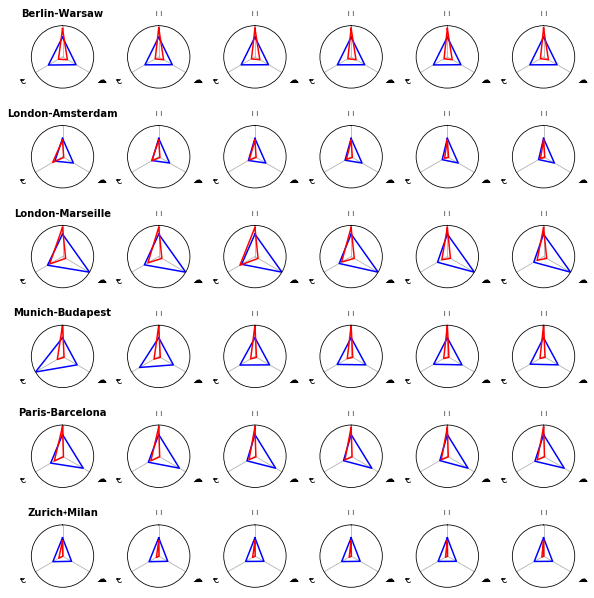

Sources: Google Flights; Trainline; IFEU EcoPassenger; Deutsche Welle analysis


In [69]:
# Reshape data to match format required by the Radar Chart function

dimensions = ['Travel time w transit', 'TicketPriceIncludingSCC', 'EcoPassengerCO2']

cases = []

for route in travel_costs['RouteWks'].unique():
    title = route
    route_data = travel_costs[travel_costs.RouteWks == route]
    case_data = route_data[dimensions].values.astype(int).tolist()
    cases.append((title, case_data))
    
data = cases

dimensions = ['Travel time w transit', 'TicketPriceIncludingSCC', 'EcoPassengerCO2']
idxdimensions = ['Travel time w transitIndex', 'TicketPriceIncludingSCCIndex', 'EcoPassengerCO2Index']

rescaled_cases = []

for route in travel_costs['RouteWks'].unique():
    title = route
    route_data = travel_costs[travel_costs.RouteWks == route]
    for dimension in dimensions:
        route_data[dimension + 'Index'] = route_data[dimension] / travel_costs[dimension].max()
    case_data = route_data[idxdimensions].values.tolist()
    rescaled_cases.append((title, case_data))
    
rescaled_data = rescaled_cases

# Plot the travel costs data on Radar Charts

# This cell adapted from https://matplotlib.org/gallery/api/radar_chart.html

N = len(dimensions)
theta = radar_factory(N, frame='circle')

spoke_labels = ['🕒', '€', '☁️']

fig, axes = plt.subplots(figsize=(10, 4), nrows=6, ncols=6,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.60, top=2, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
labels = ['Plane', 'Train']

# Plot the cases from the data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), rescaled_data):
    ax.set_rgrids([])
    if int(title[-1]) > 1:
        title = ''
    else:
        title = title[:-1]
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
    
    ax.set_varlabels(spoke_labels)
    ax.set_ylim(0,1)
    
print('Train vs plane: journey time, carbon emissions and ticket price with added Social Cost of Carbon')
plt.show()
print('Sources: Google Flights; Trainline; IFEU EcoPassenger; Deutsche Welle analysis')

Train vs plane: journey time, carbon emissions and ticket price with added Social Cost of Carbon


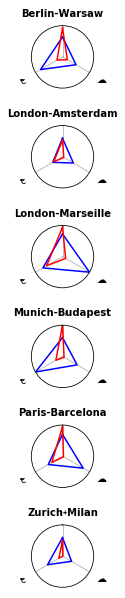

Prices averaged over 6 weeks
Sources: Google Flights; Trainline; IFEU EcoPassenger; Deutsche Welle analysis


In [70]:
travel_costs_averaged['Travel time w transit'] = travel_costs_averaged['Raw travel time'] + (180 * (travel_costs_averaged['Mode'] == 'Plane'))

# Reshape data to match format required by the Radar Chart function

dimensions = ['Travel time w transit', 'TicketPriceIncludingSCC', 'EcoPassengerCO2']

cases = []

for route in travel_costs_averaged['Route'].unique():
    title = route
    route_data = travel_costs_averaged[travel_costs_averaged.Route == route]
    case_data = route_data[dimensions].values.astype(int).tolist()
    cases.append((title, case_data))
    
data = cases

dimensions = ['Travel time w transit', 'TicketPriceIncludingSCC', 'EcoPassengerCO2']
idxdimensions = ['Travel time w transitIndex', 'TicketPriceIncludingSCCIndex', 'EcoPassengerCO2Index']

rescaled_cases = []

for route in travel_costs_averaged['Route'].unique():
    title = route
    route_data = travel_costs_averaged[travel_costs_averaged.Route == route]
    for dimension in dimensions:
        route_data[dimension + 'Index'] = route_data[dimension] / travel_costs_averaged[dimension].max()
    case_data = route_data[idxdimensions].values.tolist()
    rescaled_cases.append((title, case_data))
    
rescaled_data = rescaled_cases

# Plot the travel costs data on Radar Charts

# This cell adapted from https://matplotlib.org/gallery/api/radar_chart.html

N = len(dimensions)
theta = radar_factory(N, frame='circle')

spoke_labels = ['🕒', '€', '☁️']

fig, axes = plt.subplots(figsize=(10, 4), nrows=6, ncols=1,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.60, top=2, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
labels = ['Plane', 'Train']

# Plot the cases from the data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), rescaled_data):
    ax.set_rgrids([])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
    
    ax.set_varlabels(spoke_labels)
    ax.set_ylim(0,1)
    
print('Train vs plane: journey time, carbon emissions and ticket price with added Social Cost of Carbon')
plt.show()
print('Prices averaged over 6 weeks')
print('Sources: Google Flights; Trainline; IFEU EcoPassenger; Deutsche Welle analysis')